# Feature Selection and Modeling
- In this notebook, we build a random forest regression model to fit the response time
- Use train-test split method for model validation (Also tried grid search and cross validation)
- Build a baseline model to compare the performance with the random forest model
- Calculate the feature importance and the feature correlation
- Repeat the above actions to select the features that optimize the model performance
- The web app for this project: http://everysecondcounts.live/

In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn.model_selection import train_test_split

from collections import Counter
import joblib

import geopandas as gp
from shapely.geometry import point, polygon

import time
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import graphviz
from IPython.core.pylabtools import figsize

%matplotlib inline

In [2]:
def plot_density(data):
    xx,ff = sns.kdeplot(data, color='blue', gridsize=1000,
                        legend=False, shade=True, linewidth = 4 ).get_lines()[0].get_data() # to get the data
    
    plt.xlabel('Response time (min)',fontsize=22,fontweight="bold")
    plt.ylabel('Density',fontsize=22,fontweight="bold")
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    plt.ylim(bottom = 0)
    plt.xlim(left = 0, right = 40);
    plt.grid(True)
    
    count = data.shape[0]
    mn = np.round(np.mean(data),2)
    med = np.round(np.median(data),2)
    peak = np.round(xx[ff==max(ff)][0],2)
    
    return count, mn, med, peak

In [3]:
def plot_density_compare(data1, data2):
    xx1,ff1 = sns.kdeplot(data1, color='#335CC5', shade=True, gridsize=1000,
                        legend=False, label = 'Estimate RT').get_lines()[0].get_data() # to get the data
    
    xx2,ff2 = sns.kdeplot(data2, color= "r", shade=True, gridsize=1000,
                        legend=False, label =  'Actual RT').get_lines()[0].get_data() # to get the data
    
    plt.xlabel('Response time (min)')
    plt.ylabel('Density');
    plt.ylim(bottom = 0)
    plt.xlim(left = 0, right = 40);
    
    count1 = data1.shape[0]
    mn1 = np.round(np.mean(data1),2)
    med1 = np.round(np.median(data1),2)
    peak1 = np.round(xx1[ff1==max(ff1)][0],2)
    
    count2 = data2.shape[0]
    mn2 = np.round(np.mean(data2),2)
    med2 = np.round(np.median(data2),2)
    peak2 = np.round(xx2[ff2==max(ff2)][0],2)
    
    return count1, mn1, med1, peak1, count2, mn2, med2, peak2

In [4]:
# Baseline prediction: the mean response time or the median response time
def naive_pred(y_train, y_test, pred_type):
    
    if pred_type == 'meanRT':
        mean = np.mean(y_train)
        err = y_test - mean
        print('Mean of train data:',mean)
    
    if pred_type == 'medianRT':
        med = np.median(y_train)
        err = y_test - med
        print('Median of train data:',med)
    
    # IQR for Baseline Model
    print('Baseline model, IQR:',np.round(np.percentile(err,75) - np.percentile(err,25),2))
    # median absolute error
    print('Baseline model, Median Absolute Rrror:',np.round(np.median(abs(err)),3),  'minutes.')
    # mean absolute error
    print('Baseline model, Mean Absolute Rrror:',np.round(np.mean(abs(err)),3), 'minutes.')
    
    figsize(8,5)
    sns.distplot(err, hist=False, rug=False, kde_kws={"lw": 4, "shade": True}) 
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    plt.xlabel('Actual - Predicted time (min)',fontsize=22,fontweight="bold")
    plt.ylabel('Density',fontsize=22,fontweight="bold");
    plt.grid(True)

In [5]:
def model_compare_plot(y_train, y_test, ynew,pred_type):
    pred_err = y_test['RespTm'] - ynew
    
    if pred_type == 'meanRT':
        mean = np.mean(y_train)
        err = y_test - mean
        print('Mean of train data:',mean)
    
    if pred_type == 'medianRT':
        med = np.median(y_train)
        err = y_test - med
        print('Median of train data:',med)
    
    print('\n***** Baseline Model Results *****')
    print('\n Mean Abs Error:', round(np.mean(abs(err)), 4), 'minutes.')
    print('\n Median Abs Error:', round(np.median(abs(err)), 4), 'minutes.')
    print('\n IQR:',np.round(np.percentile(err,75) - np.percentile(err,25),2), 'minutes.')
    
    print('\n***** Random Forest Model Results *****')
    print('\n Mean Abs Error:', round(np.mean(abs(pred_err)), 4), 'minutes.')
    print('\n Median Abs Error:', round(np.median(abs(pred_err)), 4), 'minutes.')
    print('\n IQR:',np.round(np.percentile(pred_err,75) - np.percentile(pred_err,25),2), 'minutes.')
    
    figsize(8,5)
    sns.distplot(err, hist=False, rug=False,label = 'Baseline Model', 
                 kde_kws={"lw": 4, "shade": True}) 
    sns.distplot(pred_err, hist=False, rug=False, color= "r", 
                 label = 'Random Forest', kde_kws={"lw": 4, "shade": True}) 
    plt.legend(fontsize='16')
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    plt.xlabel('Actual - Predicted time (min)',fontsize=22, fontweight="bold")
    plt.ylabel('Density',fontsize=22, fontweight="bold");
    plt.grid(True)

In [6]:
def plot_feature_importances(model,X):
    n_features = X.shape[1]
    figsize(10,10)
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X.columns) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
    return model.feature_importances_

# Feature Selection
- Categorical variables: Call Type Group, Number of Alarms, Unit Type, Final Priority, month, day, dayofweek, hour
- Numerical variables:  Latitude, Longitude, min dist to hospital, min dist to fire station
- Target (continious): RespTm

In [7]:
df = pd.read_csv("model_fire_hosp.csv",index_col=0)

/Users/Jinwen/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (23,24,34) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
# Calculate the mean response time within each zipcode.
# This feature does not help significantly to improve accuracy. 
# Did not use this feature in the final model.

'''
df.dropna(subset=['Zipcode of Incident'], inplace=True)
df_zip = df[['Zipcode of Incident','RespTm']]
df_zip  = df_zip.groupby('Zipcode of Incident', as_index=False)['RespTm'].mean()

dic = {}
for index, val in df_zip.iterrows(): 
    zipcode = val["Zipcode of Incident"]
    avg = val["RespTm"]; 
    dic[zipcode] = avg

df["ZipMeanResp"] = df["Zipcode of Incident"].map(dic)
'''

'\ndf.dropna(subset=[\'Zipcode of Incident\'], inplace=True)\ndf_zip = df[[\'Zipcode of Incident\',\'RespTm\']]\ndf_zip  = df_zip.groupby(\'Zipcode of Incident\', as_index=False)[\'RespTm\'].mean()\n\ndic = {}\nfor index, val in df_zip.iterrows(): \n    zipcode = val["Zipcode of Incident"]\n    avg = val["RespTm"]; \n    dic[zipcode] = avg\n\ndf["ZipMeanResp"] = df["Zipcode of Incident"].map(dic)\n'

#### Select features and remove the irrelevant columns

In [9]:
columns = ['Call Type Group', 'Unit Type', 'ALS Unit','Final Priority',
           'Latitude','Longitude', 'dist_fire_min','dist_hosp_min',
           'dayofweek','hour', 'month','RespTm']

In [10]:
df = df[columns]

In [11]:
# Convert categorical variable from type number to type string
df['Final Priority'] = df['Final Priority'].astype(str)
df['hour'] = df['hour'].astype(str)
df['dayofweek'] = df['dayofweek'].astype(str)
df['month'] = df['month'].astype(str)

#### Also try to use the following features. They are not included in the final model.

- df['Zipcode of Incident'] = df['Zipcode of Incident'].astype(str)
- df['Number of Alarms'] = df['Number of Alarms'].astype(str)
- df['Call Final Disposition'] = df['Call Final Disposition'].astype(str)

In [12]:
# Double check if there is missing value
df.head(2)
print(df.isnull().sum())

Call Type Group    0
Unit Type          0
ALS Unit           0
Final Priority     0
Latitude           0
Longitude          0
dist_fire_min      0
dist_hosp_min      0
dayofweek          0
hour               0
month              0
RespTm             0
dtype: int64


In [13]:
# One-hot Encoding
df_OneHot = pd.get_dummies(df)
df_OneHot.head(2)
print(df_OneHot.shape)

(749340, 64)


# Train-Test Split
Randomly choose 80% of data for training and the rest 20% for testing.

In [14]:
y = df_OneHot[['RespTm']]
print(y.shape)

(749340, 1)


In [15]:
X = df_OneHot.drop('RespTm', 1)
print(X.shape)

(749340, 63)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.2, shuffle = True)

In [17]:
# Split into train and test by year. 
# Could potentially make the distribution of the test and training data different.
# Did not use this method in the final model

'''
X_train = X.iloc[150001:-1]   # rest rows of dataframe ~80%
X_test  = X.iloc[0:150000]    # first 150000 rows of dataframe ~20%
    
y_train = y.iloc[150001:-1]
y_test =  y.iloc[0:150000]
'''

'\nX_train = X.iloc[150001:-1]   # rest rows of dataframe ~80%\nX_test  = X.iloc[0:150000]    # first 150000 rows of dataframe ~20%\n    \ny_train = y.iloc[150001:-1]\ny_test =  y.iloc[0:150000]\n'

In [18]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(599472, 63)
(149868, 63)
(599472, 1)
(149868, 1)


In [19]:
X_test.head(2)

,ALS Unit,Latitude,Longitude,dist_fire_min,dist_hosp_min,Call Type Group_Alarm,Call Type Group_Fire,Call Type Group_Non Life-threatening,Call Type Group_Potentially Life-Threatening,Unit Type_CHIEF,...,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9
403758,True,37.785326,-122.417092,0.003483,0.004466,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
724483,True,37.781762,-122.411058,0.009320,0.013280,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# Export the features to build the web app
'''
export_df = X_test[:1].to_csv(r'dummyApp.csv')
'''

"\nexport_df = X_test[:1].to_csv(r'dummyApp.csv')\n"

## Random Forest Regression


In [21]:
def rf_reg(X_train,y_train,X_test,y_test,log_trans,trees,depth):
    
    if log_trans == True:
        y_train = np.log(y_train)
        y_test  = np.log(y_test) 
 
    rf = RandomForestRegressor(n_estimators=trees, 
                                  criterion='mse', 
                                  random_state = 0, 
                                  max_depth=depth,
                                  verbose = 0,
                                  oob_score = True,
                                  n_jobs = -1)
    
    print('\n*****  Random Forest Start Fitting *****')
    rf.fit(X_train, y_train)
    
    print('\n*****  Starting Predicting *****')
    ynew = rf.predict(X_test)

    if log_trans == True:
        y_train = np.exp(y_train)
        y_test  = np.exp(y_test)
        
    # prediction error
    pred_err = y_test['RespTm'] - ynew

    print('\n*****  Results *****')
    # Mean and median absolute error (MAE)
    print('Mean Abs Error:', round(np.mean(abs(pred_err)), 4), 'minutes.')
    print('Median Abs Error:', round(np.median(abs(pred_err)), 4), 'minutes.')
    print("Accuracy on training set: {:.3f}".format(rf.score(X_train, y_train))) 
    print("Accuracy on test set: {:.3f}".format(rf.score(X_test, y_test)))

    return rf, ynew

In [22]:
def evaluate_model(y_test,y_pred):
    # prediction error
    pred_err = y_test['RespTm'] - ynew

    print('\n*****  Results *****')
    # Mean and median absolute error (MAE)
    print('Mean Abs Error:', round(np.mean(abs(pred_err)), 4), 'minutes.')
    print('Median Abs Error:', round(np.median(abs(pred_err)), 4), 'minutes.')
    # IQR for Baseline Model
    print('IQR:',np.round(np.percentile(pred_err,75) - np.percentile(pred_err,25),2))
    
    figsize(8,5)
    sns.distplot(pred_err, hist=False, rug=False) 
    plt.xlabel('Actual - Predicted time (min)')
    plt.ylabel('Density');

In [23]:
log_trans = False
depth = 16
trees = 100

In [24]:
rf, ynew = rf_reg(X_train,y_train,X_test,y_test,log_trans,trees,depth)


*****  Random Forest Start Fitting *****


/Users/Jinwen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()



*****  Starting Predicting *****

*****  Results *****
Mean Abs Error: 3.0452 minutes.
Median Abs Error: 1.9608 minutes.
Accuracy on training set: 0.419
Accuracy on test set: 0.324


In [25]:
# To export the trained model to build the web app.

#joblib.dump(rf, 'RandomForestApp.mdl')

## Random Forest Grid Search 
- Used grid search and 5-fold cross validation to tune the parameters of the random forest model.
- As a result, the accuracy on test set is improved slightly.
- However, this method is conputationally expensive and takes long time.

In [26]:
def random_forest_search(X_train, y_train,X_test, y_test, param_grid,folds):

    rf = RandomForestRegressor()
    
    print('Begine grid search ....')
    grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                               cv = folds, n_jobs = -1, verbose = 1)
    
    print('Grid search finished....Begine fitting...')
    grid_search.fit(X_train, y_train)
    
    print("Best parameters: {}".format(grid_search.best_params_))
    print("Train-set score: {:.3f}".format(grid_search.score(X_train, y_train)))
    print("Test-set score: {:.3f}".format(grid_search.score(X_test, y_test)))

    return grid_search.best_params_

In [27]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [14, 16, 18],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300]
}

In [ ]:
folds = 5
best_params = random_forest_search(X_train, y_train,X_test, y_test, param_grid,folds)

## Baseline Model
The baseline model will return the mean or the median value of the training set.

Test response time : count =  599472  mean =  9.12  median =  7.33  peak =  5.79


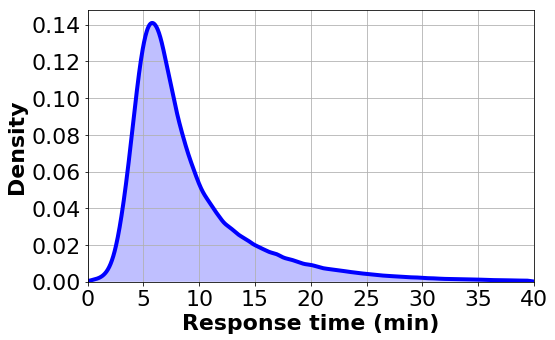

In [28]:
figsize(8,5)
count, mn, med, peak = plot_density(y_train['RespTm'])
print('Test response time : count = ',count, ' mean = ', mn, ' median = ', med, ' peak = ',peak)

Mean of train data: RespTm    9.123439
dtype: float64
Baseline model, IQR: 5.38
Baseline model, Median Absolute Rrror: 3.257 minutes.
Baseline model, Mean Absolute Rrror: RespTm    4.085
dtype: float64 minutes.


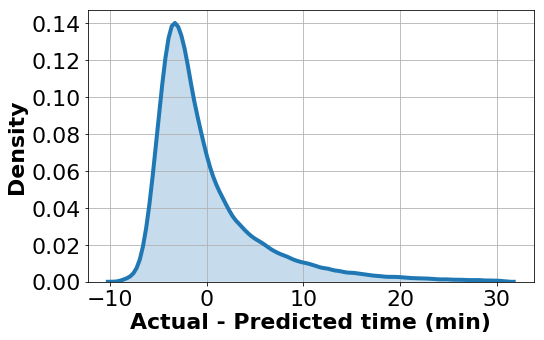

In [29]:
pred_type = 'meanRT'
#pred_type = 'medianRT'
naive_err = naive_pred(y_train, y_test, pred_type)

## Compare Baseline and RF Model
- Compare the error distribution of the two models.
- Compare the median absolute error of the two models to evaluate accuracy.
- Compare the IQR of the two medols to evaluate reliability.

Mean of train data: RespTm    9.123439
dtype: float64

***** Baseline Model Results *****

 Mean Abs Error: RespTm    4.0846
dtype: float64 minutes.

 Median Abs Error: 3.2568 minutes.

 IQR: 5.38 minutes.

***** Random Forest Model Results *****

 Mean Abs Error: 3.0452 minutes.

 Median Abs Error: 1.9608 minutes.

 IQR: 3.59 minutes.


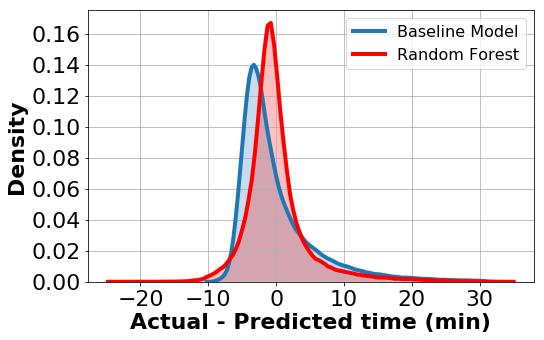

In [30]:
pred_type == 'meanRT'
#pred_type == 'medianRT'
model_compare_plot(y_train, y_test, ynew, pred_type )

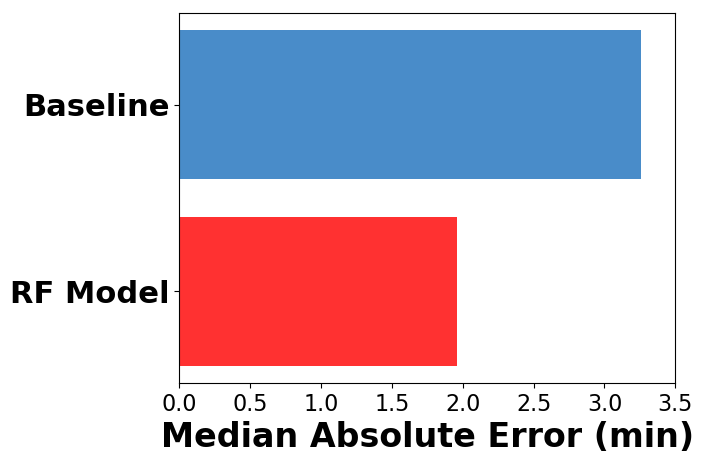

In [31]:
plt.rcdefaults()
fig, ax = plt.subplots()
mae_label = ('Baseline','RF Model')
y_pos = np.arange(len(mae_label))
mae = [3.2568,1.9608]

ax.barh(y_pos, mae, align='center', color=['#3d85c6f0', '#ff0000ce'])
ax.set_yticks(y_pos)
ax.set_yticklabels(mae_label,fontsize=18)
ax.invert_yaxis()  
ax.set_xlabel('Median Absolute Error (min)',fontsize=24,fontweight='bold')
plt.xlim(left = 0, right = 3.5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=22,fontweight='bold')
plt.show()

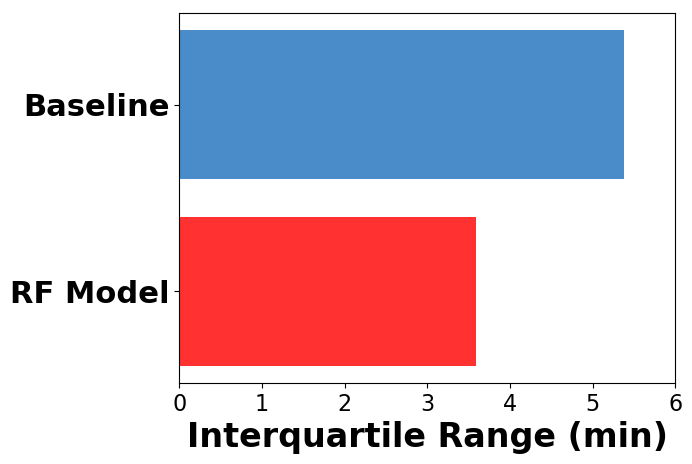

In [32]:
plt.rcdefaults()
fig, ax = plt.subplots()
IQR_label = ('Baseline','RF Model')
y_pos = np.arange(len(IQR_label))
IQR = [5.38, 3.59]

ax.barh(y_pos, IQR, align='center', color=['#3d85c6f0', '#ff0000ce'])
ax.set_yticks(y_pos)
ax.set_yticklabels(IQR_label,fontsize=18)
ax.invert_yaxis()  
ax.set_xlabel('Interquartile Range (min)',fontsize=24,fontweight='bold')
plt.xlim(left = 0, right = 6)
plt.xticks(fontsize=16)
plt.yticks(fontsize=22,fontweight='bold')
plt.show()

## Feature Importance
- Plot the feature importance derived form the trained random forest regression model.
- Aggregate the importance scores of the categorical features, e.g., day, month, hour,unit type.

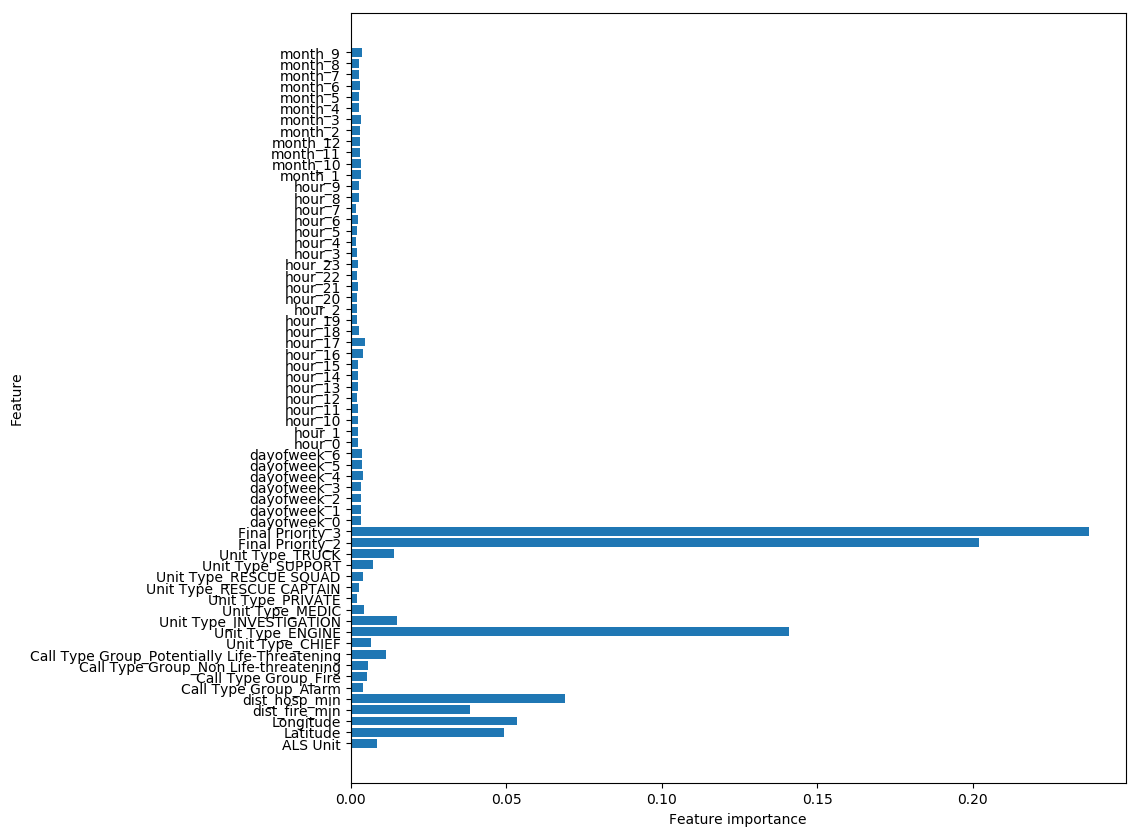

In [33]:
featImp = plot_feature_importances(rf, X)

In [34]:
featImpt_dic = {}
for ind, f in enumerate(featImp):  
    featImpt_dic[X.columns[ind]] = f

ft = pd.DataFrame(featImpt_dic, index=[0])
ft.head(2)

,ALS Unit,Latitude,Longitude,dist_fire_min,dist_hosp_min,Call Type Group_Alarm,Call Type Group_Fire,Call Type Group_Non Life-threatening,Call Type Group_Potentially Life-Threatening,Unit Type_CHIEF,...,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9
0,0.008634,0.049338,0.053515,0.038353,0.068984,0.003992,0.005362,0.005577,0.011401,0.00652,...,0.002986,0.002923,0.003016,0.00336,0.002825,0.002738,0.002979,0.002608,0.002766,0.003589


In [35]:
day_loc = ft.columns.get_loc("dayofweek_0")
hour_loc = ft.columns.get_loc("hour_0")
month_loc = ft.columns.get_loc("month_1")
print(day_loc, hour_loc, month_loc)

20 27 51


In [36]:
ft['Hour of day'] = ft.iloc[0,hour_loc:hour_loc+24].sum()
ft['Day of week'] = ft.iloc[0,day_loc:day_loc+7].sum()
ft['Month of year'] = ft.iloc[0,month_loc:month_loc+12].sum()

In [37]:
ft = ft.drop(ft.columns[day_loc:month_loc+12], axis='columns')

In [38]:
unit_loc = ft.columns.get_loc("Unit Type_CHIEF")
unit_test = ft.iloc[0,unit_loc:unit_loc+9]
ft['Vehicle Type'] = ft.iloc[0,unit_loc:unit_loc+9].sum()
ft = ft.drop(ft.columns[unit_loc:unit_loc+9], axis='columns')

In [39]:
call_loc = ft.columns.get_loc("Call Type Group_Alarm")
call_test = ft.iloc[0,call_loc:call_loc+4]
ft['Call Type'] = ft.iloc[0,call_loc:call_loc+4].sum()
ft = ft.drop(ft.columns[call_loc:call_loc+4], axis='columns')

In [40]:
ft = ft.sort_values(by =0, axis=1,ascending=True)

In [41]:
# Rename the columns into interpretable labels
ft.columns = ['ALS Included Y/N', 'Day of week','Call Type',
              'Month of Year','Min Dist to Fire Station',
              'Latitude', 'Longitude','Hour of day',
              'Min Dist to Hospital','Vehicle Type',
              'Priority Non-Emerg','Priority Emerg']

In [42]:
print(ft[['Day of week','Month of Year','Min Dist to Fire Station','Hour of day','Min Dist to Hospital']].sum().sum())
print(ft.sum().sum())

0.2260582497712049
0.9999999999999999


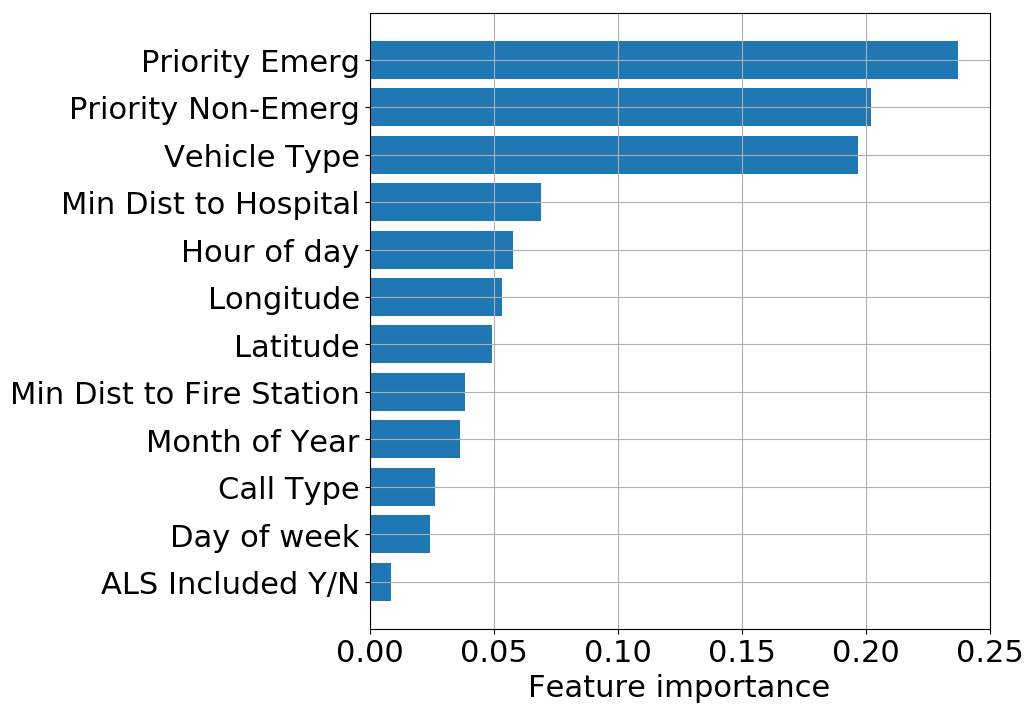

In [43]:
n_features = ft.shape[1]
figsize(8,8)
plt.barh(range(n_features), ft.values[0,:], align='center') 
plt.yticks(np.arange(n_features), ft.columns) 
plt.xlabel("Feature importance", fontsize=22)
plt.xlim(left = 0, right = 0.25)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.grid()

## Feature Correlation

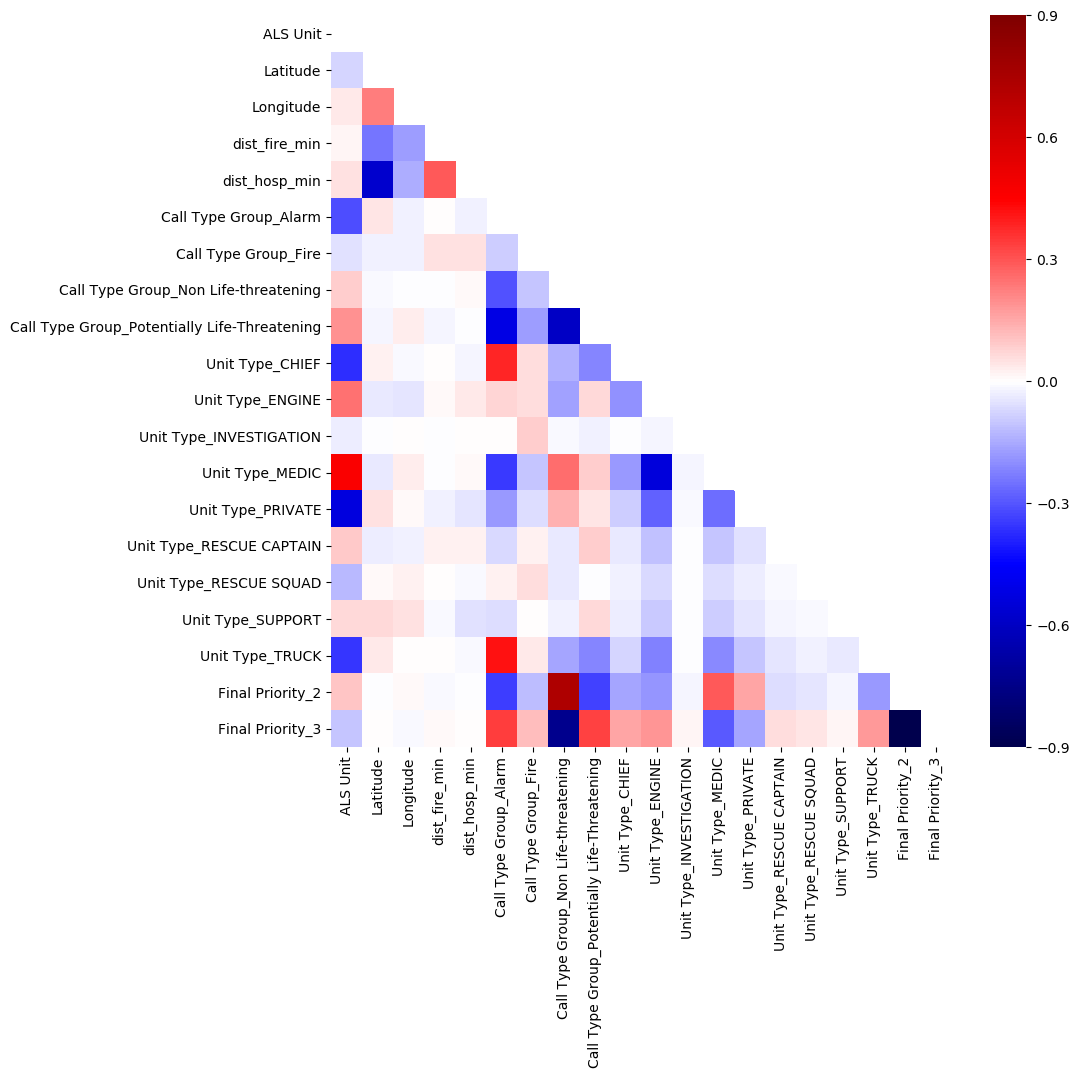

In [44]:
corr_vars = ['ALS Unit', 'Latitude', 'Longitude', 'dist_fire_min', 'dist_hosp_min',
             'Call Type Group_Alarm', 'Call Type Group_Fire',
             'Call Type Group_Non Life-threatening',
             'Call Type Group_Potentially Life-Threatening', 'Unit Type_CHIEF',
             'Unit Type_ENGINE', 'Unit Type_INVESTIGATION', 'Unit Type_MEDIC',
             'Unit Type_PRIVATE', 'Unit Type_RESCUE CAPTAIN',
             'Unit Type_RESCUE SQUAD', 'Unit Type_SUPPORT', 'Unit Type_TRUCK',
             'Final Priority_2', 'Final Priority_3']

corr = X_train[corr_vars].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(150, 275, s=80, l=55, n=9)

figsize(10,9.5)
sns.heatmap(corr, mask=mask, vmin = -.9, vmax = .9, cmap='seismic')